In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
import statsmodels.api as sm
import statsmodels.formula.api as smf
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from lib import marginal_query
from lib.DataFrameData import DataFrameData
from lib.markov_network import MarkovNetworkJax, MarkovNetworkTorch
from lib import max_ent_inference as mei
from lib import privacy_accounting
from lib import lr
from lib import rubin
from lib import confidence_interval_comparison as cic
from lib.plot_ci_comparison import plot_confidence_interval_comparison
from lib.plot_dataframe_marginal_comparison import plot_dataframe_marginal_comparison
from lib.mst import MST_selection

from mbi import Dataset, Domain, FactoredInference

from jax.config import config
config.update("jax_enable_x64", True) 
import jax
import jax.numpy as jnp

/Users/oraisa/homebrew/Caskroom/miniforge/base/envs/napsu-mq-env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
dtypes = {
    "age": int, "workclass": "category", "education": "category", "marital-status": "category",
    "occupation": "category", "relationship": "category", "race": "category", "gender": "category",
    "capital-gain": int, "capital-loss": int, "hours-per-week": int, 
    "native-country": "category", "income": bool
}
df = pd.read_csv("datasets/adult.csv", na_values=["?"], dtype=dtypes, true_values=[">50K"], false_values=["<=50K"])
df.drop(columns=[
    "fnlwgt", "educational-num", "native-country", 
    "occupation", "relationship",
], inplace=True)
df.dropna(inplace=True)
df["age"] = pd.cut(df["age"], 5)
df["hours-per-week"] = pd.cut(df["hours-per-week"], 5)
df["capital-gain"] = (df["capital-gain"] > 0).astype("category")
df["capital-loss"] = (df["capital-loss"] > 0).astype("category")
df

,age,workclass,education,marital-status,race,gender,capital-gain,capital-loss,hours-per-week,income
0,"(16.927, 31.6]",Private,11th,Never-married,Black,Male,False,False,"(20.6, 40.2]",False
1,"(31.6, 46.2]",Private,HS-grad,Married-civ-spouse,White,Male,False,False,"(40.2, 59.8]",False
2,"(16.927, 31.6]",Local-gov,Assoc-acdm,Married-civ-spouse,White,Male,False,False,"(20.6, 40.2]",True
3,"(31.6, 46.2]",Private,Some-college,Married-civ-spouse,Black,Male,True,False,"(20.6, 40.2]",True
5,"(31.6, 46.2]",Private,10th,Never-married,White,Male,False,False,"(20.6, 40.2]",False
...,...,...,...,...,...,...,...,...,...,...
48837,"(16.927, 31.6]",Private,Assoc-acdm,Married-civ-spouse,White,Female,False,False,"(20.6, 40.2]",False
48838,"(31.6, 46.2]",Private,HS-grad,Married-civ-spouse,White,Male,False,False,"(20.6, 40.2]",True
48839,"(46.2, 60.8]",Private,HS-grad,Widowed,White,Female,False,False,"(20.6, 40.2]",False
48840,"(16.927, 31.6]",Private,HS-grad,Never-married,White,Male,False,False,"(0.902, 20.6]",False


In [3]:
high_income_df = df[df.income]
high_income_df.race.value_counts()

White                 10367
Black                   552
Asian-Pac-Islander      403
Amer-Indian-Eskimo       53
Other                    47
Name: race, dtype: int64

In [4]:
cols_in_lr = ["income", "age", "race", "gender"]
c_df = df.copy()[cols_in_lr]
c_df["age_continuous"] = c_df.age.apply(lambda age: age.mid).astype(float)
c_df.drop(columns=["age"], inplace=True)
c_df["income"] = c_df["income"].astype(int)
oh_df = pd.get_dummies(c_df)
oh_df.drop(columns=["race_White", "gender_Female"], inplace=True)

model = sm.GLM(oh_df["income"], sm.add_constant(oh_df.drop(columns=["income"])), family=sm.families.Binomial())
orig_result = model.fit()
orig_distributions = cic.statsmodels_result_to_distributions(orig_result)
orig_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 income   No. Observations:                46043
Model:                            GLM   Df Residuals:                    46036
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23468.
Date:                Thu, 02 Feb 2023   Deviance:                       46937.
Time:                        15:01:02   Pearson chi2:                 4.53e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09608
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.4330      0.045    -76.327      0.000      -3.521      -3.345
age_continuous              0.0365      0.001     43.302      0.000       0.035       0.038
race_Amer-Indian-Eskimo    -0.8011      0.151     -5.322      0.000      -1.096      -0.506
race_Asian-Pac-Islander     0.1861      0.063      2.953      0.003       0.063       0.310
race_Black                 -0.7196      0.049    -14.795      0.000      -0.815      -0.624
race_Other                 -0.7437      0.161     -4.616      0.000      -1.059      -0.428
gender_Male                 1.2135      0.029     41.496      0.000       1.156       1.271
===========================================================================================
"""

In [5]:
cat_df = df.copy()
cat_df["income"] = df["income"].astype("category")
df_data = DataFrameData(cat_df)

epsilon = 1
delta = df_data.n ** (-2)

In [6]:
df_data.get_domain_size()

1792000

In [7]:
feature_sets = [("age", "income"), ("race", "income"), ("gender", "income"), ("race", "gender"), ("hours-per-week", "income")]

domain_key_list = list(df_data.values_by_col.keys())
domain_value_count_list = [len(df_data.values_by_col[key]) for key in domain_key_list]
domain = Domain(domain_key_list, domain_value_count_list)
cliques = MST_selection(Dataset(df_data.int_df, domain), 0.5, delta, cliques_to_include=feature_sets)

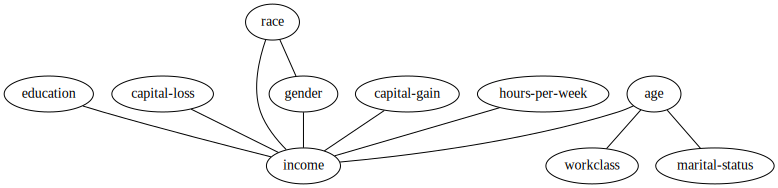

In [8]:
query_sets = cliques
queries = marginal_query.FullMarginalQuerySet(query_sets, df_data.values_by_col)
queries = queries.get_canonical_queries()

mn = MarkovNetworkTorch(df_data.values_by_col, queries)
mnjax = MarkovNetworkJax(df_data.values_by_col, queries)
mn.graph.visualize()


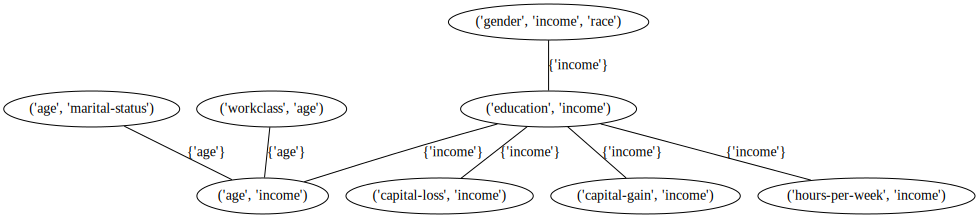

In [9]:
mnjax.junction_tree.visualize()

In [10]:
def query_matrix_rank(domain, queries):
    mat = queries(domain.get_x_values()).double()
    mat = torch.cat([mat, torch.ones((mat.shape[0], 1))], dim=1)
    return torch.linalg.matrix_rank(mat).item()

rank = query_matrix_rank(df_data, queries.flatten())
print("Rank: {}, queries: {}".format(rank - 1, len(queries.flatten().queries)))

Rank: 130, queries: 130


In [11]:
int_tensor = df_data.int_tensor
suff_stat = torch.sum(queries.flatten()(int_tensor), axis=0)
sensitivity = np.sqrt(2 * len(query_sets))
sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
dp_suff_stat = torch.normal(mean=suff_stat.double(), std=sigma_DP)

pgm_queries = marginal_query.FullMarginalQuerySet(queries.feature_sets, df_data.values_by_col)
measurements = []
for query_set in pgm_queries.feature_sets:
    q = pgm_queries.query_feature_set_sum(query_set, int_tensor).numpy()
    q_dp = q + np.random.normal(loc=0, scale=sigma_DP, size=q.shape[0])
    I_q = np.eye(q.shape[0])
    measurements.append((I_q, q_dp, sigma_DP, query_set))

Fails: 0
Final loss: 1011.0825545315095


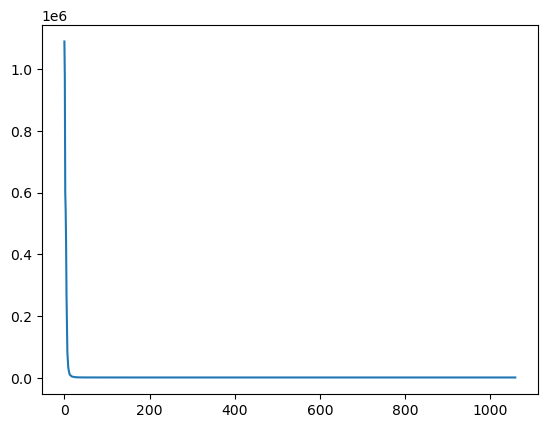

In [12]:
laplace_approx, lap_losses, fail_count = mei.laplace_approximation_normal_prior(dp_suff_stat, df_data.n, sigma_DP, mn, max_retries=5, max_iters=600)
print("Fails: {}".format(fail_count))
print("Final loss: {}".format(lap_losses[-1]))
plt.plot(lap_losses)
plt.show()

In [13]:
rng = jax.random.PRNGKey(6473286482)
mcmc, backtransform = mei.run_numpyro_mcmc_normalised(
    rng, dp_suff_stat, df_data.n, sigma_DP, mnjax, laplace_approx, num_samples=2000, num_warmup=800, num_chains=4
)

  0%|          | 0/2800 [00:00<?, ?it/s]2023-02-02 15:08:03.570586: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit__body_fn.115
********************************
sample: 100%|██████████| 2800/2800 [14:30<00:00,  3.22it/s, 127 steps of size 3.13e-02. acc. prob=0.93]


In [14]:
inf_data = az.from_numpyro(mcmc, log_likelihood=False)
pd.options.display.max_rows = 200
pd.options.display.width = 1000
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
norm_lambdas[0],0.854,1.170,-1.304,3.002,0.018,0.013,4287.0,5036.0,1.00
norm_lambdas[1],0.027,0.994,-1.897,1.819,0.008,0.012,13998.0,5915.0,1.00
norm_lambdas[2],-0.098,1.015,-1.942,1.855,0.009,0.014,11438.0,5470.0,1.00
norm_lambdas[3],-0.449,1.078,-2.475,1.498,0.013,0.015,9204.0,4452.0,1.00
norm_lambdas[4],-0.198,0.996,-2.098,1.612,0.009,0.012,11829.0,5781.0,1.00
norm_lambdas[5],-0.016,0.999,-1.866,1.870,0.009,0.012,12122.0,6367.0,1.00
norm_lambdas[6],0.007,1.001,-1.905,1.844,0.009,0.012,12659.0,5634.0,1.00
norm_lambdas[7],-0.053,1.023,-2.067,1.771,0.009,0.012,11934.0,5029.0,1.00
norm_lambdas[8],-0.097,1.027,-2.062,1.805,0.010,0.012,10773.0,5919.0,1.00
norm_lambdas[9],-0.173,0.994,-1.979,1.719,0.009,0.012,12158.0,5698.0,1.00


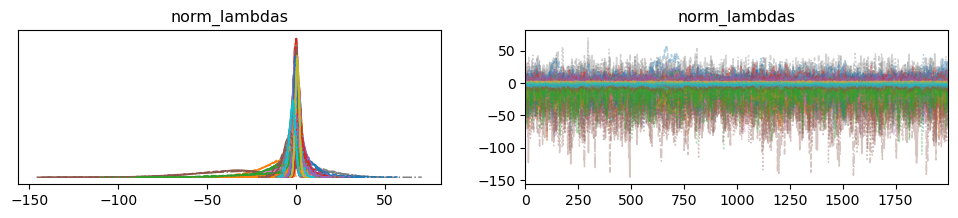

In [15]:
az.plot_trace(inf_data)
# plt.savefig("latex/figures/inference_trace.pdf")
plt.show()

In [16]:
posterior_values = inf_data.posterior.stack(draws=("chain", "draw"))
posterior_values = backtransform(posterior_values.norm_lambdas.values.transpose())

In [17]:
n_syn_datasets = 25
n_syn_dataset = df_data.n

In [18]:
engine = FactoredInference(domain, log=True)
model = engine.estimate(measurements, engine="MD")

syn_data_pgm = model.synthetic_data(n_syn_dataset).df
syn_df_pgm = df_data.ndarray_to_cat_df(syn_data_pgm.values)

Total clique size: 155
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		19103.19		3514818.54		0.00
50.00		0.17		1433.56		11029.69		0.00
100.00		0.37		578.70		1627.21		0.00
150.00		0.56		362.95		641.87		0.00
200.00		0.74		268.89		358.46		0.00
250.00		0.92		214.59		233.82		0.00
300.00		1.12		179.81		167.03		0.00
350.00		1.31		155.03		126.87		0.00
400.00		1.51		137.67		100.98		0.00
450.00		1.71		124.02		82.86		0.00
500.00		1.89		113.66		69.96		0.00
550.00		2.08		105.63		60.47		0.00
600.00		2.27		99.11		53.29		0.00
650.00		2.45		94.13		47.82		0.00
700.00		2.66		89.58		43.38		0.00
750.00		2.86		85.71		39.83		0.00
800.00		3.05		82.35		36.96		0.00
850.00		3.24		79.70		34.60		0.00
900.00		3.43		77.64		32.64		0.00
950.00		3.60		76.08		31.00		0.00


In [19]:
syn_dfs_pgm_repeats = []
n_pgm_repeats = 10
for i in tqdm(range(n_pgm_repeats)):
    sensitivity_repeats = np.sqrt(2 * len(query_sets) * n_pgm_repeats)
    sigma_DP_repeats = privacy_accounting.sigma(epsilon, delta, sensitivity_repeats)
    measurements = []
    for query_set in pgm_queries.feature_sets:
        q = pgm_queries.query_feature_set_sum(query_set, int_tensor).numpy()
        q_dp = q + np.random.normal(loc=0, scale=sigma_DP_repeats, size=q.shape[0])
        I_q = np.eye(q.shape[0])
        measurements.append((I_q, q_dp, sigma_DP_repeats, query_set))
    engine = FactoredInference(domain, log=False)
    model = engine.estimate(measurements, engine="MD")

    syn_data_pgm = model.synthetic_data(n_syn_dataset).df
    syn_df_pgm = df_data.ndarray_to_cat_df(syn_data_pgm.values)
    syn_dfs_pgm_repeats.append(syn_df_pgm)

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


In [20]:
posterior_values = np.array(laplace_approx.sample((n_syn_datasets * 100,)))
rng = jax.random.PRNGKey(4623428)
rng, posterior_key = jax.random.split(rng)
inds = jax.random.choice(posterior_key, posterior_values.shape[0], (n_syn_datasets,))
posterior_sample = posterior_values[inds, :]
rng, *syn_data_keys = jax.random.split(rng, n_syn_datasets + 1)
syn_int_dfs = [mnjax.sample(syn_data_key, jnp.array(posterior_value), n_syn_dataset) for syn_data_key, posterior_value in zip(syn_data_keys, posterior_sample)]
syn_dfs = [df_data.int_df_to_cat_df(syn_data) for syn_data in syn_int_dfs]

In [21]:
syn_df_mn = df_data.int_df_to_cat_df(mn.sample(laplace_approx.mean, n_syn_dataset))

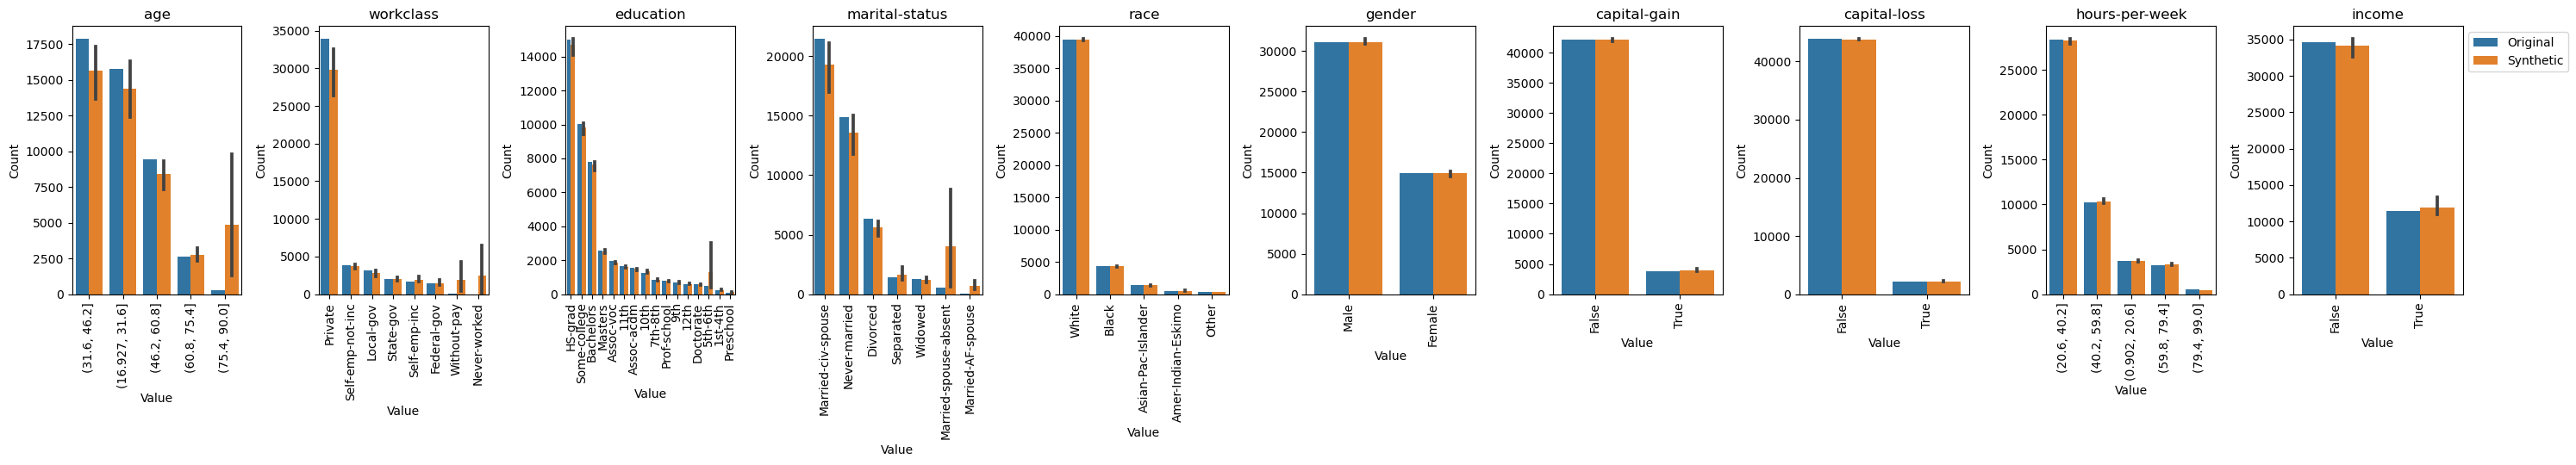

In [22]:
plot_dataframe_marginal_comparison(df, syn_dfs)#, filename="latex/figures/adult-reduced-0.1-mcmc-1-way.pdf")

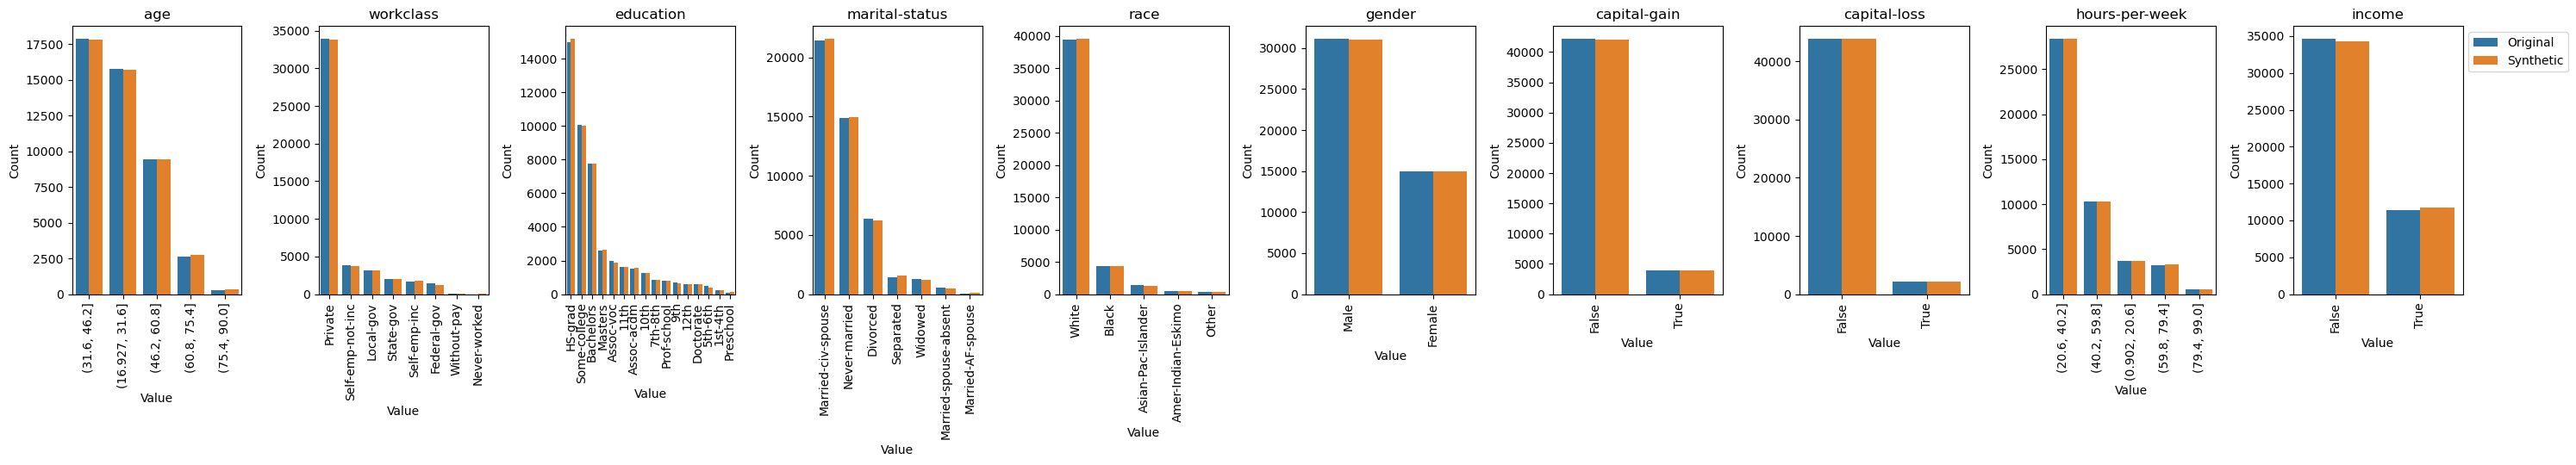

In [23]:
plot_dataframe_marginal_comparison(df, [syn_df_mn])

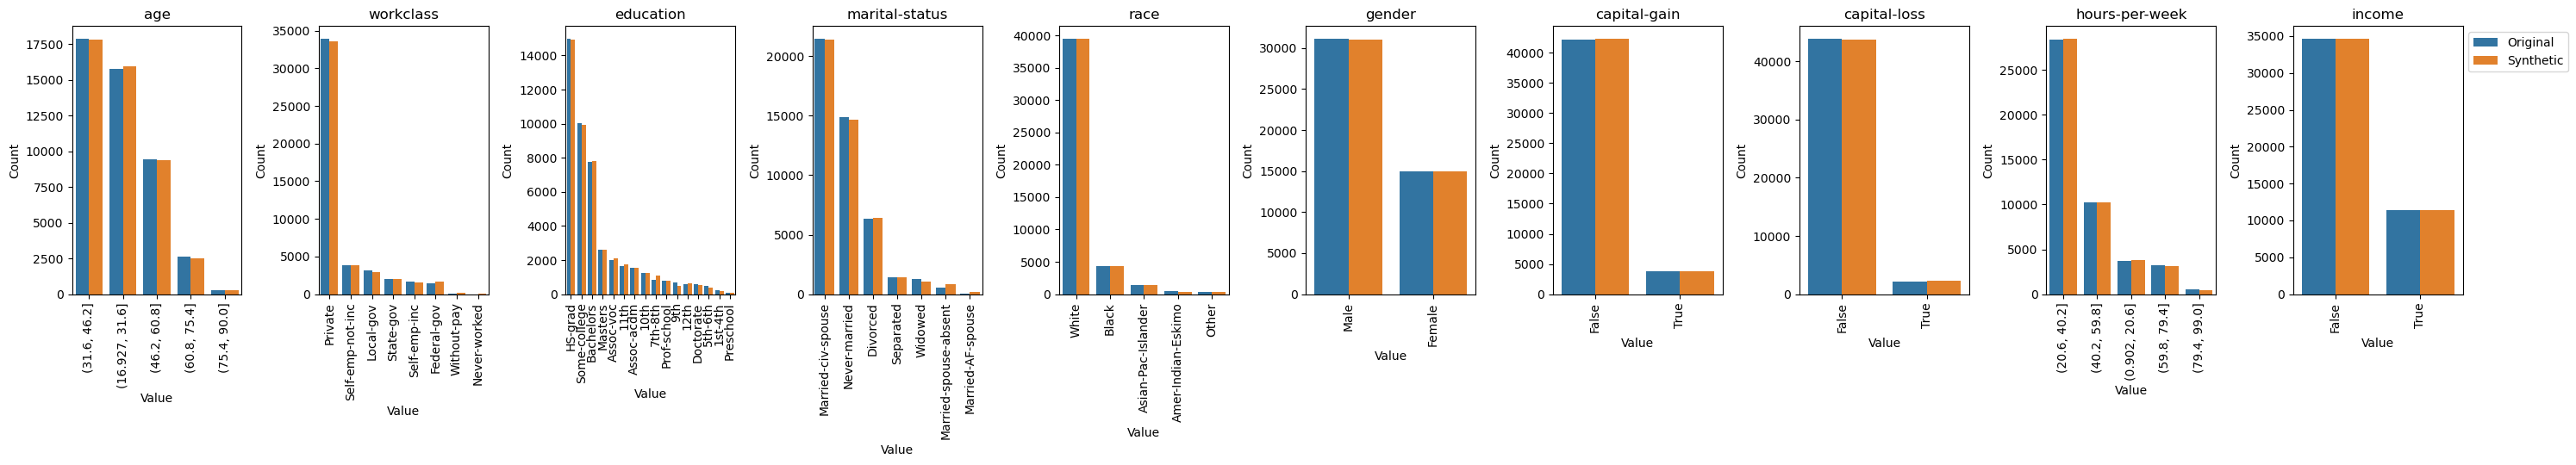

In [24]:
plot_dataframe_marginal_comparison(df, [syn_df_pgm])

In [25]:
workload_values = queries.flatten()(int_tensor).sum(dim=0)
syn_df_query_values = [torch.sum(queries.flatten()(DataFrameData(syn_df).int_tensor), axis=0) for syn_df in syn_dfs]

suff_stat_by_query = pd.DataFrame.from_records([
    (
        "{} = {}".format(*df_data.int_query_to_str_query(query.inds, query.value)), 
        workload_values[i].item(),
        "Real Data"
    ) for i, query in enumerate(queries.flatten().queries)
] + [
    (
        "{} = {}".format(*df_data.int_query_to_str_query(query.inds, query.value)), 
        syn_df_query_value[i].item(),
        "Synthetic Data"
    )
    for i, query in enumerate(queries.flatten().queries)
    for syn_df_query_value in syn_df_query_values
], columns=["Query", "Count", "Type"])

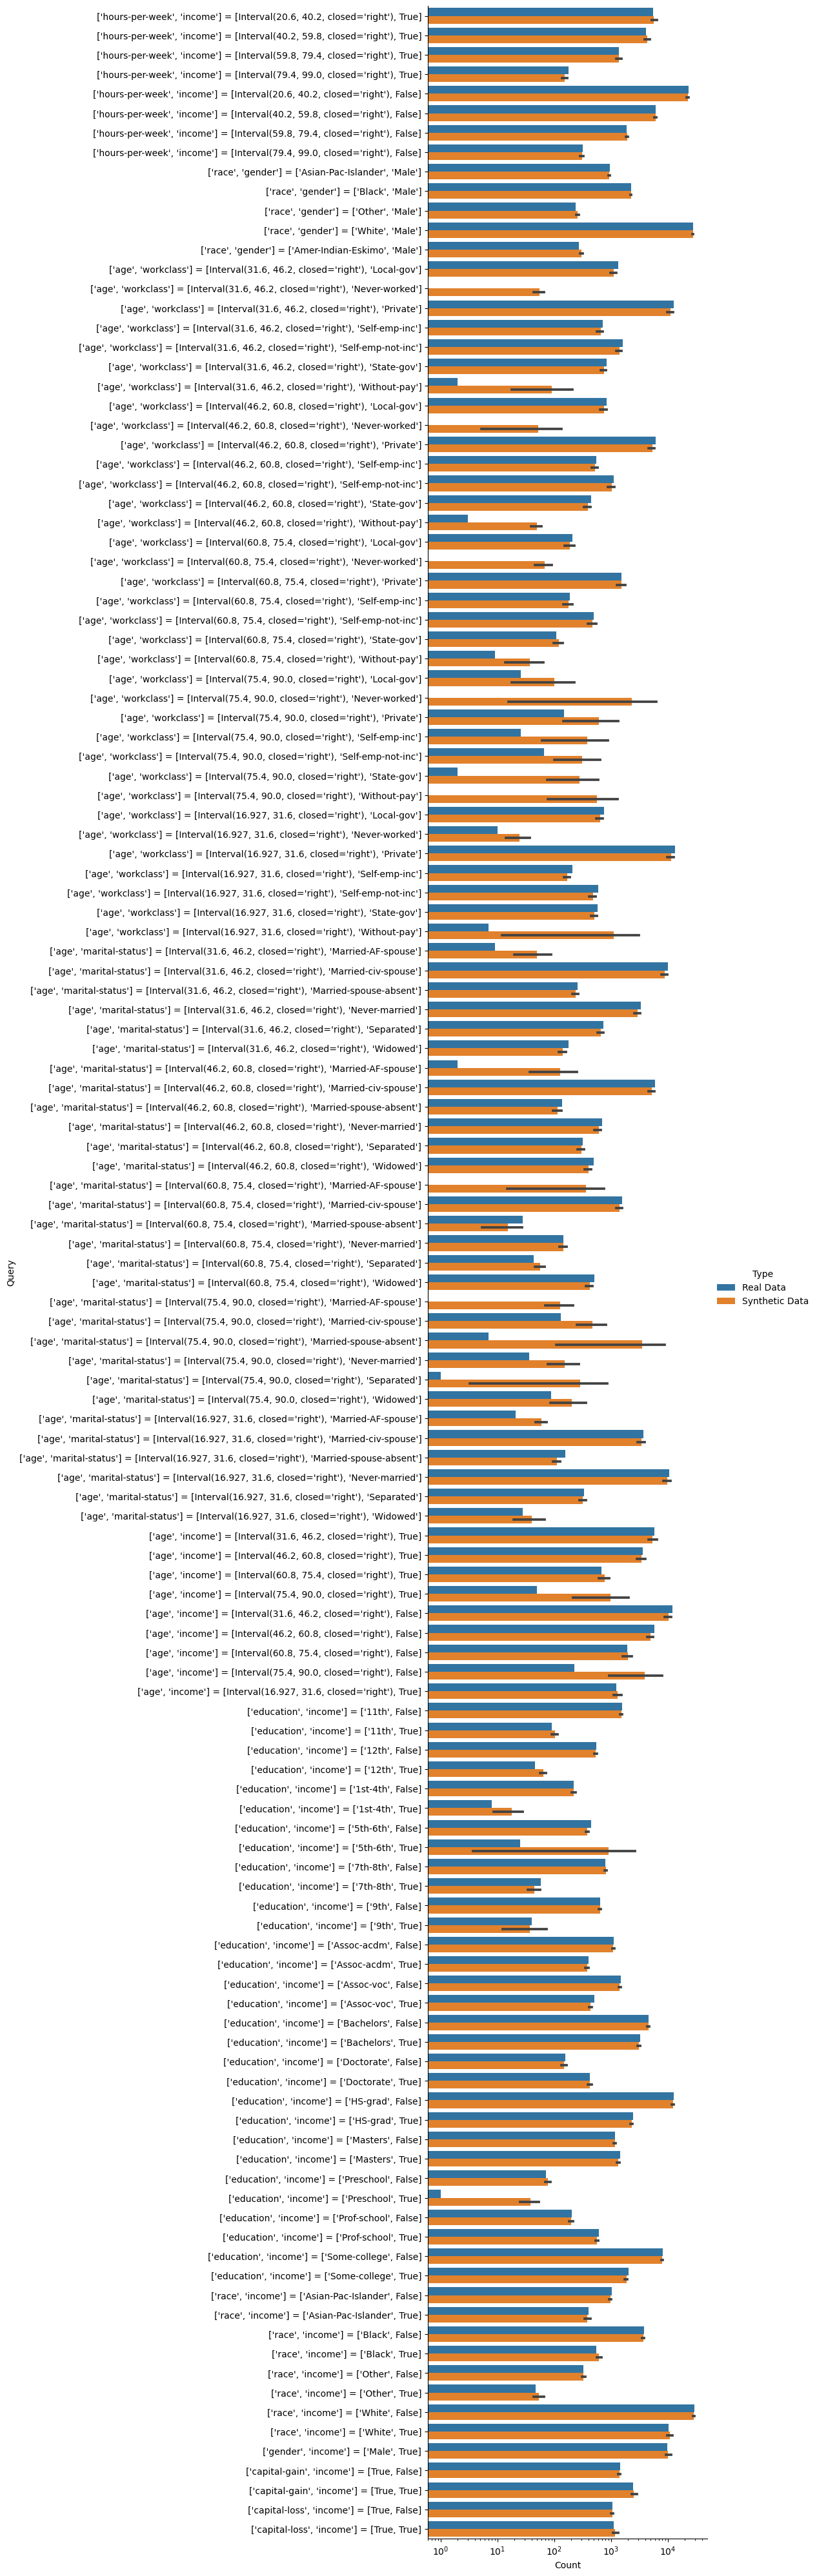

In [26]:
sns.catplot(x="Count", y="Query", hue="Type", kind="bar", data=suff_stat_by_query, height=40, aspect=0.3)
plt.xscale("log")
plt.show()

In [27]:
def df_transform(df):
    c_df = df.copy()[cols_in_lr]
    c_df["income"] = c_df["income"].astype(int)
    c_df["age_continuous"] = c_df.age.apply(lambda age: age.mid).astype(float)
    c_df.drop(columns=["age"], inplace=True)
    syn_oh_df = pd.get_dummies(c_df)
    syn_oh_df.drop(columns=["race_White", "gender_Female"], inplace=True)
    syn_oh_df = syn_oh_df.reindex(columns=oh_df.columns, fill_value=0)
    return syn_oh_df

oh_syn_dfs = [df_transform(syn_df) for syn_df in syn_dfs]
oh_syn_dfs_pgm = [df_transform(syn_df) for syn_df in syn_dfs_pgm_repeats]

In [28]:
syn_datasets = np.stack([df.values for df in oh_syn_dfs])
syn_datasets_pgm = np.stack([df.values for df in oh_syn_dfs_pgm])

In [29]:
q, u, conf_ints_individual = lr.logistic_regression(syn_datasets, 0, add_constant=True, return_intervals=True, conf_levels=[0.95])
q_pgm, u_pgm, conf_ints_individual_pgm = lr.logistic_regression(syn_datasets_pgm, 0, add_constant=True, return_intervals=True, conf_levels=[0.95])

In [30]:
n_conf_ints = q.shape[1]
conf_ints = np.zeros((n_conf_ints, 2))
conf_ints_reg = np.zeros((n_conf_ints, 2))
conf_ints_pgm = np.zeros((n_conf_ints, 2))
for i in range(n_conf_ints):
    qi = q[:, i]
    ui = u[:, i]
    inds = (ui < 1000)
    qi = qi[inds]
    ui = ui[inds]
    mi = qi.shape[0]
    conf_ints[i, :] = rubin.non_negative_conf_int(qi, ui, 0.95, n_syn_dataset, df_data.n)
    conf_ints_pgm[i, :] = rubin.non_negative_conf_int(q_pgm[:,i], u_pgm[:,i], 0.95, n_syn_dataset, df_data.n)

In [31]:
oh_syn_df_pgm = df_transform(syn_df_pgm)
pgm_model = sm.GLM(oh_syn_df_pgm["income"], sm.add_constant(oh_syn_df_pgm.drop(columns=["income"])), family=sm.families.Binomial())
pgm_result = pgm_model.fit()
pgm_conf_ints = pgm_result.conf_int(1 - 0.95).values
pgm_distributions = cic.statsmodels_result_to_distributions(pgm_result)

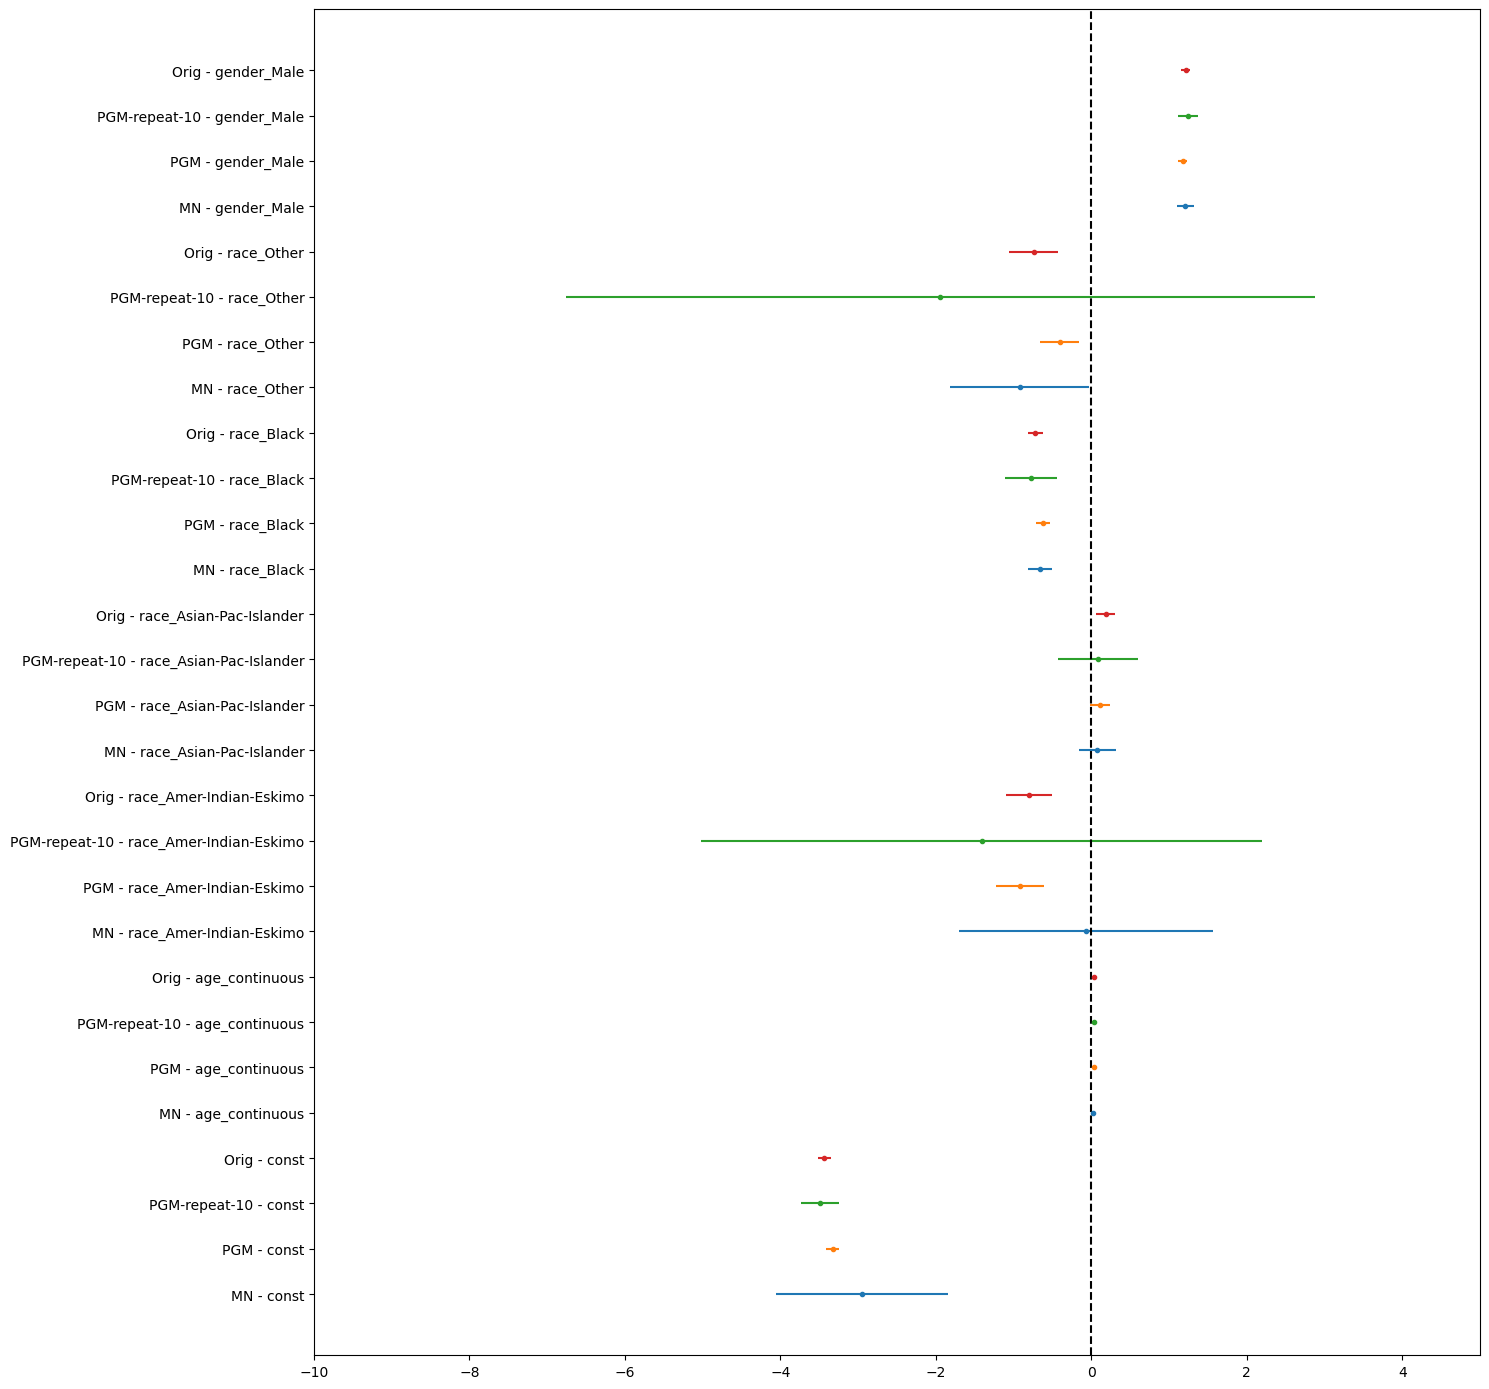

In [32]:
variable_index = orig_result.conf_int(1 - 0.95).index
orig_conf_ints = orig_result.conf_int(1 - 0.95).values
plot_confidence_interval_comparison(
    [
        ("MN", conf_ints), 
        ("PGM", pgm_conf_ints), 
        ("PGM-repeat-{}".format(n_pgm_repeats), conf_ints_pgm), 
        ("Orig", orig_conf_ints)
    ], 
    variable_index, 
    xlim=(-10, 5), 
    # filename="latex/figures/adult-reduced/cis_test.pdf"
)